In [39]:
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.python.keras.layers import Conv3D, ReLU, MaxPooling3D, Reshape, Dense, Dropout, SeparableConv2D, MaxPooling2D, Conv2D
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Bidirectional, Flatten, LSTM
from tensorflow.python.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from frame_extraction import Frames

## Frame extraction class

In [40]:
class Frames_V2(Frames):
    @staticmethod
    def read_img(filename):
        """
        method for reading images and converting to numpy array
        """
        frame = cv2.imread(filename)
        return cv2.resize(frame, (64, 64))

    @classmethod
    def read_fr(cls, arr):
        videos = []
        for index, video in enumerate(arr):
            print("Completed", round(index / len(arr) * 100, 2), end="\r")

            # if the file is .tif file
            if video.endswith(".tif"):
                videos.append(cls.read_img(video))
                continue

            caption = cv2.VideoCapture(video)
            frame_rate = caption.get(Frames.fps)

            while caption.isOpened():
                frame_id = caption.get(1)
                ret, frame = caption.read()

                if not ret:
                    break

                if frame_id % np.floor(frame_rate) == 0:
                    videos.append(cv2.resize(frame, (64, 64)))

            caption.release()

        return videos

In [41]:
classes = ["NonViolence", "Violence"]

In [42]:
file_list = []
for name in classes:
    file_names = glob.glob(f"dataset/Real Life Violence Dataset/{name}/*.*")
    file_list.extend(file_names)

## Pre processing dataset

In [45]:
# violence dataset
violence = list(filter(lambda x: "/violence" in x.lower(), file_list))

In [46]:
non_violence = list(filter(lambda x: "/nonviolence" in x.lower(), file_list))

In [47]:
violence_arr = Frames_V2.read_fr(violence)

In [48]:
non_violence_arr = Frames_V2.read_fr(non_violence)

02Completed 4.29Completed 4.66Completed 4.9Completed 5.29Completed 5.63Completed 5.74Completed 6.0Completed 6.28Completed 6.6Completed 6.81Completed 7.03Completed 7.35Completed 7.64Completed 7.78Completed 7.88Completed 8.28Completed 8.42Completed 8.79Completed 8.95Completed 9.29Completed 9.7Completed 10.02Completed 10.26Completed 10.57Completed 10.98Completed 11.09Completed 11.43Completed 11.74Completed 12.06Completed 12.16Completed 12.28Completed 12.68Completed 12.92Completed 13.23Completed 13.46Completed 13.66Completed 13.96Completed 14.19Completed 14.31Completed 14.53Completed 14.85Completed 15.07Completed 15.38Completed 15.71Completed 16.03Completed 16.4Completed 16.45Completed 16.78Completed 17.04Completed 17.1Completed 17.31Completed 17.52Completed 17.75Completed 18.06Completed 18.27Completed 18.59Completed 18.92Completed 19.34Completed 19.66Completed 19.87Completed 20.2Completed 20.41Completed 20.73Completed 21.07Completed 21.39Completed 21.59Completed 21.7Completed 21.8Complete

In [49]:
violence_arr = np.asarray(violence_arr)
non_violence_arr = np.asarray(non_violence_arr)

In [50]:
# Training data
X = np.concatenate((violence_arr, non_violence_arr), axis=0)

### 1 is meant for violence and 0 is meant for non violence

In [51]:
Y = np.array([1 for _ in range(violence_arr.shape[0])] + [0 for _ in range(non_violence_arr.shape[0])])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

## Creating model

In [53]:
Model = Sequential()

Model.add(SeparableConv2D(12,(3,3),activation="relu",
                 input_shape=(64,64,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

#
Model.add(SeparableConv2D(24,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2,2)))


#
Model.add(TimeDistributed(Flatten()))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))

#
Model.add(Flatten())
Model.add(Dense(128,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(1,activation="sigmoid"))

In [54]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 62, 62, 12)        75        
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 62, 62, 12)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 12)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 31, 31, 24)        420       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 24)        0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 15, 360)           0

In [55]:
Model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [56]:
Model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=7)

Epoch 1/7
1689/1689 [==============================] - 148s 78ms/step - loss: 0.3260 - accuracy: 0.8271 - val_loss: 0.2520 - val_accuracy: 0.8761
Epoch 2/7
1689/1689 [==============================] - 129s 76ms/step - loss: 0.2373 - accuracy: 0.8848 - val_loss: 0.2275 - val_accuracy: 0.8799
Epoch 3/7
1689/1689 [==============================] - 130s 77ms/step - loss: 0.1953 - accuracy: 0.9103 - val_loss: 0.1790 - val_accuracy: 0.9169
Epoch 4/7
1689/1689 [==============================] - 131s 78ms/step - loss: 0.1652 - accuracy: 0.9292 - val_loss: 0.1643 - val_accuracy: 0.9292
Epoch 5/7
1689/1689 [==============================] - 137s 81ms/step - loss: 0.1475 - accuracy: 0.9381 - val_loss: 0.1540 - val_accuracy: 0.9363
Epoch 6/7
1689/1689 [==============================] - 131s 77ms/step - loss: 0.1283 - accuracy: 0.9456 - val_loss: 0.1469 - val_accuracy: 0.9363
Epoch 7/7
1689/1689 [==============================] - 134s 79ms/step - loss: 0.1157 - accuracy: 0.9520 - val_loss: 0.1436 -

In [57]:
Model.save("saved_model_v3")

INFO:tensorflow:Assets written to: saved_model_v3\assets


INFO:tensorflow:Assets written to: saved_model_v3\assets


In [58]:
loss, accuracy = Model.evaluate(X_test, y_test)

132/132 [==============================] - 4s 28ms/step - loss: 0.1436 - accuracy: 0.9448


In [59]:
print(f"Accuracy: {round(accuracy * 100, 3)} %")

Accuracy: 94.481 %


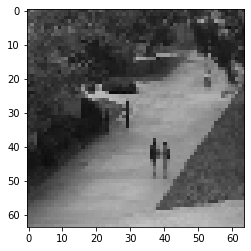

In [60]:
plt.imshow(X_test[0])

In [61]:
y_test[0]

0

## Loading saved model

In [2]:
model = tf.keras.models.load_model("saved_model_v2")

In [3]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_16 (Separa  (None, 62, 62, 12)       75        
 bleConv2D)                                                      
                                                                 
 module_wrapper_9 (ModuleWra  (None, 62, 62, 12)       0         
 pper)                                                           
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 12)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_17 (Separa  (None, 31, 31, 24)       420       
 bleConv2D)                                                      
                                                                 
 dropout_8 (Dropout)         (None, 31, 31, 24)       

## Training nodel on custom dataset

In [8]:
file_list = []
for name in classes:
    file_names = glob.glob(f"dataset/Custom/{name}/*.*")
    file_list.extend(file_names)
violence = list(filter(lambda x: "/violence" in x.lower(), file_list))
non_violence = list(filter(lambda x: "/nonviolence" in x.lower(), file_list))
violence_arr = Frames_V2.read_fr(violence)
non_violence_arr = Frames_V2.read_fr(non_violence)
violence_arr = np.asarray(violence_arr)
non_violence_arr = np.asarray(non_violence_arr)
X = np.concatenate((violence_arr, non_violence_arr), axis=0)
Y = np.array([1 for _ in range(violence_arr.shape[0])] + [0 for _ in range(non_violence_arr.shape[0])])

ompleted 14.29Completed 57.14

In [9]:
model.fit(X, Y, epochs=7, batch_size=10)

Epoch 1/7
11/11 [==============================] - 11s 44ms/step - loss: 0.8838 - accuracy: 0.5686
Epoch 2/7
11/11 [==============================] - 0s 42ms/step - loss: 0.7210 - accuracy: 0.6961
Epoch 3/7
11/11 [==============================] - 0s 39ms/step - loss: 0.4420 - accuracy: 0.7941
Epoch 4/7
11/11 [==============================] - 1s 49ms/step - loss: 0.4552 - accuracy: 0.8039
Epoch 5/7
11/11 [==============================] - 1s 64ms/step - loss: 0.3895 - accuracy: 0.8529
Epoch 6/7
11/11 [==============================] - 1s 58ms/step - loss: 0.3885 - accuracy: 0.8922
Epoch 7/7
11/11 [==============================] - 1s 58ms/step - loss: 0.3290 - accuracy: 0.8824


In [10]:
model.save("saved_model_v3")

INFO:tensorflow:Assets written to: saved_model_v3\assets


INFO:tensorflow:Assets written to: saved_model_v3\assets


In [37]:
x = Frames_V2.read_fr(['dataset/Real Life Violence Dataset/NonViolence/NV_1001.mp4'])

In [38]:
Frames_V2.select_fr(x).shape

(6, 5, 64, 3)